<a href="https://colab.research.google.com/github/asya474/final_project/blob/main/final_project_first_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import time
import csv
import sys
import os
!pip install tensorflow_addons -q
import tensorflow_addons as tfa
import re
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import *
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import *

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

#print(os.listdir("/content/drive/MyDrive/Colab Notebooks/input"))


     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [2]:
RANDOM_SEED = 42
VAL_SIZE = 0.20 
mape=mean_absolute_percentage_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## EDA

In [4]:
zip_file='/content/drive/MyDrive/data.csv.zip'
z=zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

['.config', 'drive', '__MACOSX', 'data.csv', 'sample_data']


In [5]:
data=pd.read_csv('data.csv')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [7]:
data.nunique()

status             159
private pool         1
propertyType      1280
street          337076
baths              229
homeFacts       321009
fireplace         1653
city              2026
schools         297365
sqft             25405
zipcode           4549
beds              1184
state               39
stories            348
mls-id           24907
PrivatePool          2
MlsId           232944
target           43939
dtype: int64

In [8]:
data.isna().sum()

status           39918
private pool    373004
propertyType     34733
street               2
baths           106338
homeFacts            0
fireplace       274070
city                34
schools              0
sqft             40577
zipcode              0
beds             91282
state                0
stories         150715
mls-id          352243
PrivatePool     336874
MlsId            66880
target            2481
dtype: int64

### target

In [9]:
data.target.value_counts()

$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
$299,900     1276
             ... 
$390,359        1
$458,900+       1
274,359         1
$273,490+       1
$171,306        1
Name: target, Length: 43939, dtype: int64

In [10]:
data['new_target'] = data['target'].str.replace('+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [11]:
data['new_target'] = data['new_target'].str.replace('$', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [12]:
data['new_target'] = data['new_target'].str.replace(',', '')

In [13]:
data['new_target']=pd.to_numeric(data['new_target'], downcast='integer', errors='coerce')

In [14]:
data['new_target'].value_counts()

225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
325000.0    1562
            ... 
218111.0       1
136466.0       1
236070.0       1
752911.0       1
171306.0       1
Name: new_target, Length: 34184, dtype: int64

In [15]:
data.drop(['target',], axis=1, inplace=True)

In [16]:
data.dropna(subset=['new_target'], inplace=True)

In [17]:
data['new_target'].describe()

count    3.743060e+05
mean     6.454072e+05
std      1.842196e+06
min      1.000000e+00
25%      1.877965e+05
50%      3.200000e+05
75%      5.845000e+05
max      1.950000e+08
Name: new_target, dtype: float64

In [18]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [19]:
#import numpy as np
#import pandas as pd
#from pandas_profiling import ProfileReport

In [20]:
#profile = ProfileReport(data, title='data_report', html={'style':{'full_width':True}})

In [21]:
#profile.to_notebook_iframe()

In [22]:
#profile.to_file(output_file="data_report.html")

### status

In [23]:
data.status.value_counts()

for sale                   156100
Active                     105206
For sale                    43465
foreclosure                  5677
New construction             5459
                            ...  
Coming soon: Nov 8.             1
Coming soon: Oct 29.            1
Coming soon: Dec 15.            1
Pending W/Backup Wanted         1
Coming soon: Dec 23.            1
Name: status, Length: 155, dtype: int64

In [24]:
data.status.unique()

array(['Active', 'for sale', nan, 'New construction', 'New', 'For sale',
       'Pending', 'P', 'Active/Contingent', ' / auction',
       'Under Contract', 'Pre-foreclosure / auction',
       'Under Contract   Showing', 'Pre-foreclosure',
       'Under Contract Backups', 'Active Under Contract', 'foreclosure',
       'Foreclosed', 'Option Pending', 'Under Contract Show', 'Auction',
       'A Active', 'Contingent', 'Pending   Continue To Show',
       'Price Change', 'Back on Market', 'Active Option', 'Foreclosure',
       'Coming soon: Nov 21.', 'Contingent Finance And Inspection',
       'Coming soon: Dec 4.', 'P Pending Sale', 'Coming soon: Nov 23.',
       'Active With Contingencies', 'Pending Ab', 'Pf', 'Contingent Show',
       'Contract P', 'Contingent Take Backup', 'Apartment for rent',
       'Backup Contract', 'Option Contract', 'Pending Continue To Show',
       'pending', 'Pending Inspection', 'Active Option Contract', 'C',
       'Auction - Active', 'Contingent   Show', 'Pi

In [25]:
data['status'] = data.status.astype(str)
data['status'] = data.status.apply(lambda x: x.split(' ')[0].lower())

In [26]:
data.status.unique()

array(['active', 'for', 'nan', 'new', 'pending', 'p', 'active/contingent',
       '', 'under', 'pre-foreclosure', 'foreclosure', 'foreclosed',
       'option', 'auction', 'a', 'contingent', 'price', 'back', 'coming',
       'pf', 'contract', 'apartment', 'backup', 'c', 'pi', 'due', 'u',
       'lease/purchase', 'offer', 'listing', 'pending,', 'contingency',
       'condo', 'ct', 'temporary', 'closed', 'accepted', 'conditional',
       'accepting', 'conting', 'ps', 're', 'reactivated', 'uc'],
      dtype=object)

In [27]:
def transform_status(
    value: str
):  
    if isinstance(value, str):
        if  value in ['for']:
            return 'for sale'
        if  value in ['nan', '']:
            return 'not known'
        if  value in ['a', 'active/contingent']:
            return 'active'
        if  value in ['price']:
            return 'price change'
        if  value in ['back', 'backup']:
            return 'back on market'
        if  value in ['coming', 'c']:
            return 'coming soon'
        if value in ['p', 'pi', 'ps']:
            return 'pending'
        if value in ['u', 'uc']:
            return 'under'
        if value in ['re']:
            return 'reactivated'
        if value in ['ct']:
            return 'contract'
        if value in ['pre-foreclosure', 'foreclosure', 'foreclosed']:
            return 'foreclosure'
        if value in ['accepting', 'accepted']:
            return 'accepted'
        if value in ['contingency', 'conting']:
            return 'contingency'
        if value in ['condo', 'conditional']:
            return 'conditional'

    return value
data.status=data.status.apply(transform_status)

In [28]:
data.status.unique()

array(['active', 'for sale', 'not known', 'new', 'pending', 'under',
       'foreclosure', 'option', 'auction', 'contingent', 'price change',
       'back on market', 'coming soon', 'pf', 'contract', 'apartment',
       'due', 'lease/purchase', 'offer', 'listing', 'pending,',
       'contingency', 'conditional', 'temporary', 'closed', 'accepted',
       'reactivated'], dtype=object)

In [29]:
data['status'].describe()

count       374306
unique          27
top       for sale
freq        199567
Name: status, dtype: object

### private pool

In [30]:
data['private pool'].value_counts()

Yes    4151
Name: private pool, dtype: int64

In [31]:
data.drop(['private pool',], axis=1, inplace=True)

### propertyType

In [32]:
data['propertyType'].value_counts()

single-family home                                             91159
Single Family                                                  61888
Single Family Home                                             31725
condo                                                          25878
lot/land                                                       20532
                                                               ...  
1 Story, Contemporary, Other (See Remarks)                         1
Custom, Elevated, Other                                            1
Contemporary, Farmhouse                                            1
2 Stories, Traditional, Mediterranean, Texas Hill Country          1
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit        1
Name: propertyType, Length: 1279, dtype: int64

In [33]:
data['propertyType'].unique()

array(['Single Family Home', 'single-family home', 'lot/land', ...,
       'Cabin/Lodge, Contemporary, Converted Barn, Cottage, Loft with Bedrooms, Log Home, Post & Beam',
       'Lake House, Single Detached, Tudor',
       'Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit'],
      dtype=object)

In [34]:
data['propertyType'] = data['propertyType'].astype(str)
data['propertyType'] = data['propertyType'].apply(lambda x: x.split(' ')[0].lower().replace(',', ''))

In [35]:
data['propertyType'].unique()
#требуется более точечная ифна с этим сериес,чем просто обрезка данных, тут и данные о стиле интерьера, и данные о колве комнат

array(['single', 'single-family', 'lot/land', 'townhouse', 'florida',
       'nan', 'coop', 'english', '2', 'multi-family', 'penthouse',
       'condo', 'land', 'condo/townhome/row', '', 'detached', '1',
       'other', 'colonial', 'transitional', 'high', 'mobile/manufactured',
       'tri-level', 'craftsman', 'federal', 'multi', 'traditional',
       'custom', 'cooperative', 'contemporary/modern', 'cape', 'mobile',
       'miscellaneous', 'mfd/mobile', 'bungalow', 'spanish/mediterranean',
       'contemporary', 'multi-level', 'condo/unit', 'ranch', 'low-rise',
       'rancher', 'urban', 'two', 'garden', 'farms/ranches', 'a-frame',
       'attached', 'one', 'georgian', 'dwelling', 'victorian',
       'apartment', 'cluster', 'manufactured', 'condominium',
       'condo/townhome', 'hi', 'mediterranean', 'cabin', 'bermuda',
       'split', 'farm', 'split-level', 'singlefamilyresidence', 'log',
       'bilevel', 'mountain', 'commercial/industrial', 'cottage',
       'high-rise', 'mid-rise'

In [36]:
def transform_status(
    value: str
):  
    if isinstance(value, str):
        if  value in ['nan', '']:
            return 'not known'
        if  value in ['1']:
            return 'one'
        if  value in ['2', '2.5', '2-story']:
            return 'two'
        if  value in ['3']:
            return 'back on market'
        if  value in ['coming', 'c']:
            return 'coming soon'
        if value in ['p', 'pi', 'ps']:
            return 'pending'
        if value in ['u', 'uc']:
            return 'under'
        if value in ['re']:
            return 'reactivated'
        if value in ['ct']:
            return 'contract'
        if value in ['pre-foreclosure', 'foreclosure', 'foreclosed']:
            return 'foreclosure'
        if value in ['accepting', 'accepted']:
            return 'accepted'
        if value in ['contingency', 'conting']:
            return 'contingency'
        if value in ['condo', 'conditional']:
            return 'conditional'

    return value
data.status=data.status.apply(transform_status)

In [37]:
data.isna().sum()

status               0
propertyType         0
street               2
baths           105288
homeFacts            0
fireplace       271878
city                34
schools              0
sqft             40111
zipcode              0
beds             90909
state                0
stories         149396
mls-id          349369
PrivatePool     334280
MlsId            64337
new_target           0
dtype: int64

### street

In [38]:
data.street.value_counts()

Address Not Disclosed               672
Undisclosed Address                 516
(undisclosed Address)               391
Address Not Available               175
Unknown Address                      72
                                   ... 
Lynmar Plan in Rough Hollow           1
MLS #: CORC5922640                    1
7784 Rosedale St                      1
Buildable plan: Residence 2 Plan      1
5983 Midcrown Dr                      1
Name: street, Length: 334447, dtype: int64

In [39]:
data['street']=data['street'].fillna(value='not known')

### baths

In [40]:
data.baths.value_counts()

2 Baths          51953
3 Baths          35356
2                20429
2.0              16355
4 Baths          14712
                 ...  
32                   1
5.25 Baths           1
41.0                 1
Bathrooms: 21        1
44.0                 1
Name: baths, Length: 225, dtype: int64

In [41]:
data['baths']=pd.to_numeric(data['baths'],  errors='coerce')

In [42]:
data['baths'].unique()

array([  3.5,   nan,   2. ,   3. ,   4. ,   1. ,   4.5,   5. ,   1.5,
         2.5,   8. ,   0. ,   7. ,   6. ,   5.5, 750. ,  10. ,  18. ,
         9. ,  12. ,   6.5,  14. ,  17. ,  16. ,   7.5,  11. ,  22. ,
        13. ,  32. ,  26. ,   9.5,   8.5,  35. ,  40. ,  29. ,  15. ,
        21. ,  20. ,  55. ,  41. ,  10.5,  27. ,  12.5,  24. ,  23. ,
        34. ,  64. ,  30. ,  44. ])

In [43]:
data['baths'].describe()

count    102741.000000
mean          4.249978
std          35.889117
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

In [44]:
data['baths']=data['baths'].fillna(value=data['baths'].mean())

In [45]:
data['baths'].unique()

array([  3.5      ,   4.2499781,   2.       ,   3.       ,   4.       ,
         1.       ,   4.5      ,   5.       ,   1.5      ,   2.5      ,
         8.       ,   0.       ,   7.       ,   6.       ,   5.5      ,
       750.       ,  10.       ,  18.       ,   9.       ,  12.       ,
         6.5      ,  14.       ,  17.       ,  16.       ,   7.5      ,
        11.       ,  22.       ,  13.       ,  32.       ,  26.       ,
         9.5      ,   8.5      ,  35.       ,  40.       ,  29.       ,
        15.       ,  21.       ,  20.       ,  55.       ,  41.       ,
        10.5      ,  27.       ,  12.5      ,  24.       ,  23.       ,
        34.       ,  64.       ,  30.       ,  44.       ])

In [46]:
data['baths']=data['baths'].astype(float).apply(lambda x:round(x, 1))

In [47]:
data['baths'].unique()

array([  3.5,   4.2,   2. ,   3. ,   4. ,   1. ,   4.5,   5. ,   1.5,
         2.5,   8. ,   0. ,   7. ,   6. ,   5.5, 750. ,  10. ,  18. ,
         9. ,  12. ,   6.5,  14. ,  17. ,  16. ,   7.5,  11. ,  22. ,
        13. ,  32. ,  26. ,   9.5,   8.5,  35. ,  40. ,  29. ,  15. ,
        21. ,  20. ,  55. ,  41. ,  10.5,  27. ,  12.5,  24. ,  23. ,
        34. ,  64. ,  30. ,  44. ])

### homeFacts

In [48]:
data.homeFacts.value_counts()

{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                                     7142
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                          3484
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factVa

### fireplace

In [49]:
data['fireplace'].value_counts()

yes                                                                     49925
Yes                                                                     20619
1                                                                       14533
2                                                                        2432
Not Applicable                                                           1990
                                                                        ...  
Gas, Wood Burning, Two, Propane Logs Convey                                 1
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: fireplace, Length: 1652, dtype: int64

In [50]:
def transform_fireplace(
    value: str
):  
    if isinstance(value, str):
        if  value in value:
          return 'yes'
data['fireplace']=data['fireplace'].apply(transform_fireplace)

In [51]:
data['fireplace'].isna().sum()

271878

In [52]:
data['fireplace']=data['fireplace'].fillna(value='not')

In [53]:
data['fireplace'].value_counts()

not    271878
yes    102428
Name: fireplace, dtype: int64

### city

In [54]:
data['city'].value_counts()

Houston            24388
San Antonio        15496
Miami              15385
Jacksonville        9890
Dallas              8750
                   ...  
Los Altos Hills        1
Lake worth             1
Lisle                  1
Arrington              1
Blue Springs           1
Name: city, Length: 2019, dtype: int64

In [55]:
data['city'].isna().sum()

34

In [56]:
data['city']=data['city'].fillna(value='Houston')

### schools

In [57]:
data.schools.value_counts()

[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]                                                                                                                                                                                                                                                                                       4169
[{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}]                                                                                                                 222
[{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']}, 'name': ['Horizon Middle School', 'Desert Hills Elementary School', 'Horizon High School']}]                                                                             

### sqft

In [58]:
data['sqft'].value_counts()

0                                          11853
1,200 sqft                                   824
1,000 sqft                                   643
1,100 sqft                                   566
1,800 sqft                                   558
                                           ...  
101,415 sqft                                   1
3938                                           1
Total interior livable area: 4,580 sqft        1
32,552 sqft                                    1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 25369, dtype: int64

In [59]:
data['sqft'].unique()

array(['2900', '1,947 sqft', '3,000 sqft', ..., '4371', '13,870 sqft',
       'Total interior livable area: 4,615 sqft'], dtype=object)

In [60]:
data['sqft'] = pd.to_numeric(data['sqft'], errors='coerce')

In [61]:
data['sqft'].value_counts()

0.0       11853
960.0       284
800.0       257
900.0       234
850.0       177
          ...  
5031.0        1
4325.0        1
4974.0        1
469.0         1
4371.0        1
Name: sqft, Length: 5427, dtype: int64

In [62]:
data['sqft'].isna().sum()

312718

In [63]:
data['sqft']=data['sqft'].fillna(round(data['sqft'].mean(), 1))

In [64]:
data['sqft'].value_counts()

8927.6    312718
0.0        11853
960.0        284
800.0        257
900.0        234
           ...  
5031.0         1
4325.0         1
4974.0         1
469.0          1
4371.0         1
Name: sqft, Length: 5428, dtype: int64

### zipcode

In [65]:
data.zipcode.value_counts()

32137         2139
33131         1551
34747         1486
78245         1383
34759         1333
              ... 
92683            1
27610-2861       1
27613-4042       1
27612-5442       1
44704            1
Name: zipcode, Length: 4541, dtype: int64

In [66]:
data['zipcode'] = pd.to_numeric(data['zipcode'], errors='coerce')

In [67]:
data['zipcode']=data['zipcode'].fillna(0)

In [68]:
data.zipcode.value_counts().plot.barh()

### beds

In [69]:
data['beds'].value_counts()

3 Beds        52947
4 Beds        35149
3             31191
2 Beds        26084
4             19915
              ...  
8.93 acres        1
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
8,479 sqft        1
Name: beds, Length: 1146, dtype: int64

In [70]:
data['beds'].unique()

array(['4', '3 Beds', '5 Beds', ..., '2.72 acres', '9,565 sqft',
       '8,479 sqft'], dtype=object)

In [71]:
def transform_beds(
    value: str
):  
    if isinstance(value, str):
        if  'acres' in value:
            return 0
        if  'sqft' in value:
            return 0
    return value
data['beds']=data['beds'].apply(transform_beds)

In [72]:
data['beds'] = pd.to_numeric(data['beds'], errors='coerce')

In [73]:
data['beds'].isna().sum()

270910

In [74]:
data['beds']=data['beds'].fillna(round(data['beds'].mean(), 0))

In [75]:
data['beds'].value_counts()

3.0      310186
4.0       25146
2.0       18427
5.0        7764
1.0        5012
0.0        4359
6.0        2103
7.0         577
8.0         357
9.0         102
10.0         77
11.0         40
12.0         36
16.0         21
14.0         15
13.0         14
15.0         11
24.0          9
20.0          7
18.0          7
17.0          4
28.0          3
30.0          3
22.0          3
26.0          2
29.0          2
34.0          2
27.0          2
32.0          2
40.0          2
99.0          1
33.0          1
21.0          1
75.0          1
19.0          1
144.0         1
48.0          1
23.0          1
44.0          1
78.0          1
35.0          1
Name: beds, dtype: int64

In [76]:
data['beds'].describe()

count    374306.000000
mean          3.036497
std           0.836125
min           0.000000
25%           3.000000
50%           3.000000
75%           3.000000
max         144.000000
Name: beds, dtype: float64

### state

In [77]:
data.state.value_counts()

FL    114570
TX     83269
NY     24329
CA     23170
NC     21768
TN     18218
WA     13730
OH     12423
IL      8823
NV      8402
GA      6632
CO      6371
PA      5493
MI      5119
DC      4581
AZ      3347
IN      3280
OR      2774
MA      1494
UT      1319
MD      1086
VT       864
MO       832
VA       800
WI       452
NJ       436
ME       258
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: state, dtype: int64

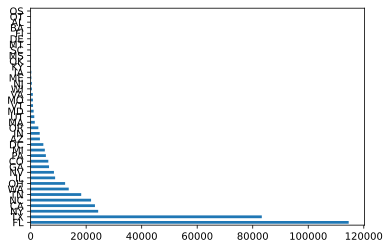

In [78]:
data.state.value_counts().plot.barh()

### stories

In [79]:
data['stories'].value_counts()

1.0                                  66808
2.0                                  55003
1                                    22795
2                                    17976
3.0                                  11233
                                     ...  
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
None                                     1
65.0                                     1
Name: stories, Length: 348, dtype: int64

In [80]:
data['stories'] = pd.to_numeric(data['stories'], errors='coerce')

In [81]:
data['stories'].value_counts()

1.0       90942
2.0       75986
3.0       15971
0.0       11440
9.0        3381
          ...  
1120.0        1
2.2           1
1002.0        1
96.0          1
65.0          1
Name: stories, Length: 85, dtype: int64

In [82]:
data['stories'].isna().sum()

167920

In [83]:
data['stories']=data['stories'].fillna(round(data['stories'].mean(), 0))

In [84]:
data['stories'].describe()

count    374306.000000
mean          1.966604
std           3.288860
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1120.000000
Name: stories, dtype: float64

### mls-id

In [85]:
data['mls-id'].value_counts()

No           3
No MLS#      3
983469       2
241766       2
A10761504    2
            ..
1020314      1
A10762436    1
1592770      1
14201834     1
F10202858    1
Name: mls-id, Length: 24902, dtype: int64

In [86]:
data.drop(['mls-id',], axis=1, inplace=True)

### PrivatePool

In [87]:
data.PrivatePool.value_counts()

yes    28592
Yes    11434
Name: PrivatePool, dtype: int64

In [88]:
data['PrivatePool']=data['PrivatePool'].fillna(value='not')

In [89]:
#data['PrivatePool'] = data['PrivatePool'].astype(str)
data['PrivatePool'] = data['PrivatePool'].apply(lambda x: x.lower())

In [90]:
data['PrivatePool'].value_counts()

not    334280
yes     40026
Name: PrivatePool, dtype: int64

### MlsId

In [91]:
data['MlsId'].value_counts()

NO MLS                     24
No MLS #                   16
 A, Houston, TX 77008      13
 12A, Orlando, FL 32833    11
 B, Houston, TX 77008       9
                           ..
241208                      1
687215                      1
3866902                     1
19491906                    1
10374233                    1
Name: MlsId, Length: 232622, dtype: int64

In [92]:
data['MlsId'] = pd.to_numeric(data['MlsId'], errors='coerce')

In [93]:
data['MlsId'].value_counts()

2101941.0     6
1412350.0     6
2088662.0     6
14187092.0    5
14061735.0    5
             ..
10589197.0    1
3481963.0     1
1418405.0     1
14135173.0    1
10374233.0    1
Name: MlsId, Length: 161084, dtype: int64

In [94]:
data=data.drop(['MlsId',], axis=1)

In [95]:
data.isna().sum()

status          0
propertyType    0
street          0
baths           0
homeFacts       0
fireplace       0
city            0
schools         0
sqft            0
zipcode         0
beds            0
state           0
stories         0
PrivatePool     0
new_target      0
dtype: int64

In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374306 entries, 0 to 377184
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        374306 non-null  object 
 1   propertyType  374306 non-null  object 
 2   street        374306 non-null  object 
 3   baths         374306 non-null  float64
 4   homeFacts     374306 non-null  object 
 5   fireplace     374306 non-null  object 
 6   city          374306 non-null  object 
 7   schools       374306 non-null  object 
 8   sqft          374306 non-null  float64
 9   zipcode       374306 non-null  float64
 10  beds          374306 non-null  float64
 11  state         374306 non-null  object 
 12  stories       374306 non-null  float64
 13  PrivatePool   374306 non-null  object 
 14  new_target    374306 non-null  float64
dtypes: float64(6), object(9)
memory usage: 45.7+ MB


# Data Preprocessing

## Label Encoding 

In [97]:
#Для построения первой модели возьмем следующие столбцы
#data=data['new_target', 'status', 'propertyType', 'street', 'baths',
#          'fireplace', 'city',  'sqft', 'zipcode', 
#          'beds', 'state', 'stories', 'PrivatePool', 'MlsId']
data=data.drop(['homeFacts', 'schools',], axis=1)
data=pd.DataFrame(data=data)

## Standartisation

In [98]:
num_features = ['baths', 'sqft', 'zipcode', 'beds',  'MlsId']

## FeatureEngineering

In [99]:
categorical_features=[ 'status', 'fireplace',  'PrivatePool']
data = pd.get_dummies(data, columns = categorical_features , prefix_sep = "_", drop_first = True)
data.head()

propertyType               street  baths            city    sqft  zipcode  \
0         single       240 Heather Ln    3.5  Southern Pines  2900.0  28387.0   
1  single-family    12911 E Heroy Ave    4.2  Spokane Valley  8927.6  99216.0   
2  single-family    2005 Westridge Rd    4.2     Los Angeles  8927.6  90049.0   
3  single-family  4311 Livingston Ave    4.2          Dallas  8927.6  75205.0   
4       lot/land       1524 Kiscoe St    4.2        Palm Bay  8927.6  32908.0   

   beds state  stories  new_target  ...  status_option  status_pending  \
0   4.0    NC      2.0    418000.0  ...              0               0   
1   3.0    WA      2.0    310000.0  ...              0               0   
2   3.0    CA      1.0   2895000.0  ...              0               0   
3   3.0    TX      3.0   2395000.0  ...              0               0   
4   3.0    FL      2.0      5000.0  ...              0               0   

   status_pending,  status_pf  status_price change  status_reactivated  \
0                0          0                    0                   0   
1                0          0                    0                   0   
2                0          0                    0                   0   
3                0          0                    0                   0   
4                0          0                    0                   0   

   status_temporary  status_under  fireplace_yes  PrivatePool_yes  
0                 0             0              1                0  
1                 0             0              0                0  
2                 0             0              1                1  
3                 0             0              1                0  
4                 0             0              0                0  

[5 rows x 38 columns]

In [100]:
le = LabelEncoder()
data['propertyType'] = le.fit_transform(data['propertyType'])
data['street'] = le.fit_transform(data['street'])
data['city'] = le.fit_transform(data['city'])
data['state'] = le.fit_transform(data['state'])
data.head()

propertyType  street  baths  city    sqft  zipcode  beds  state  stories  \
0           149  124833    3.5  1705  2900.0  28387.0   4.0     21      2.0   
1           150   43403    4.2  1715  8927.6  99216.0   3.0     37      2.0   
2           150  102248    4.2  1031  8927.6  90049.0   3.0      3      1.0   
3           150  197986    4.2   430  8927.6  75205.0   3.0     33      3.0   
4           105   68022    4.2  1341  8927.6  32908.0   3.0      7      2.0   

   new_target  ...  status_option  status_pending  status_pending,  status_pf  \
0    418000.0  ...              0               0                0          0   
1    310000.0  ...              0               0                0          0   
2   2895000.0  ...              0               0                0          0   
3   2395000.0  ...              0               0                0          0   
4      5000.0  ...              0               0                0          0   

   status_price change  status_reactivated  status_temporary  status_under  \
0                    0                   0                 0             0   
1                    0                   0                 0             0   
2                    0                   0                 0             0   
3                    0                   0                 0             0   
4                    0                   0                 0             0   

   fireplace_yes  PrivatePool_yes  
0              1                0  
1              0                0  
2              1                1  
3              1                0  
4              0                0  

[5 rows x 38 columns]

## Data Split

In [101]:
X = data.drop(['new_target'], axis=1)
y = data['new_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# ML

## An AdaBoost regressor

In [102]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 5000, num = 10)]

#random_grid = {'n_estimators': n_estimators}
#abr = AdaBoostRegressor(random_state=42)
#abr_random = RandomizedSearchCV(estimator=abr, param_distributions=random_grid, n_iter=10, 
#                               cv=3, verbose=2, random_state=42, return_train_score=True)
#abr_random.fit(X_train, np.log(y_train))
#print(abr_random.best_params_)

In [103]:
abr = AdaBoostRegressor(random_state=42, n_estimators= 200)
abr.fit(X_train, np.log(y_train))

AdaBoostRegressor(n_estimators=200, random_state=42)

In [104]:
predict_test_abr = np.exp(abr.predict(X_test))

In [105]:
print((mape(y_test, predict_test_abr)))

12.18714328918924


## Gradient Boosting for regression.

In [ ]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]

#random_grid = {'n_estimators': n_estimators}
#gbr = GradientBoostingRegressor(random_state=42)
#gbr_random = RandomizedSearchCV(estimator=gbr, param_distributions=random_grid, n_iter=30, 
#                               cv=3, verbose=2, random_state=42, return_train_score=True)
#gbr_random.fit(X_train, np.log(y_train))
#print(gbr_random.best_params_)

In [107]:

gbr = GradientBoostingRegressor(random_state=42,
                              n_estimators=1000)
gbr.fit(X_train, np.log(y_train))

GradientBoostingRegressor(n_estimators=1000, random_state=42)

In [108]:
predict_test_gbr = np.exp(gbr.predict(X_test))

In [109]:
print((mape(y_test, predict_test_gbr)))

10.887834980346561


## A random forest regressor.

In [110]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
#min_samples_split=[1, 2, 3, 5]
#min_samples_leaf=[1, 2, 3, 5]
#max_features=[0.25, 0.5, 0.75, 1.0]
#bootstrap=[True, False]
#max_depth = [int(x) for x in np.linspace(70, 200, num = 11)]
#max_depth.append(None)


#random_grid = {'n_estimators': n_estimators,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'max_features': max_features,
#               'bootstrap': bootstrap,
#               'max_depth': max_depth}
#rf = RandomForestRegressor(random_state=42)
#rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=3, 
#                               cv=3, verbose=2, random_state=42, return_train_score=True)
#rf_random.fit(X_train, np.log(y_train))
#print(rf_random.best_params_)


In [111]:
rf = RandomForestRegressor(random_state=42,
                           n_estimators=600 ,
                            max_depth=161,
                           min_samples_split=2 ,
                           min_samples_leaf=3 ,
                            max_features=0.75,
                            bootstrap=False )
rf.fit(X_train, np.log(y_train))
#{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.75, 'max_depth': 161, 'bootstrap': False}

RandomForestRegressor(bootstrap=False, max_depth=161, max_features=0.75,
                      min_samples_leaf=3, n_estimators=600, random_state=42)

In [112]:
predict_test_rt = np.exp(rf.predict(X_test))

In [113]:
print((mape(y_test, predict_test_rt)))

26.318397853195233


## Stack of estimators with a final regressor.

In [115]:
estimators = [('abr', AdaBoostRegressor(n_estimators=200, 
                          random_state=RANDOM_SEED)),
             ('gbr', GradientBoostingRegressor(random_state=42,
                        n_estimators=1000))]
sr = StackingRegressor(estimators=estimators,
                      final_estimator=None,
                      n_jobs=1, 
                       cv=2, 
                       passthrough= False)
sr.fit(X_train, np.log(y_train))
predict_test = np.exp(sr.predict(X_test))

print((mape(y_test, predict_test)))

10.77024059093791
